In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [2]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [25]:
M  = 2                  # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 0.8          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([10, 10])  # each age group has asymptomatic infectives
Is0 = np.array([10, 10])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('sto_traj.npy', data_array)

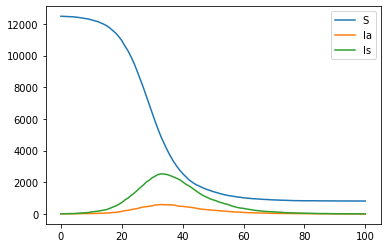

In [26]:
plt.plot(data_array[:, 0], label='S')
plt.plot(data_array[:, M], label='Ia')
plt.plot(data_array[:, 2*M], label='Is')
plt.legend()
plt.show()

In [27]:
# load the data and rescale to intensive variables 
Tf = 20 # truncate to only getting the first few datapoints 
Nf = Tf+1

x = np.load('sto_traj.npy').astype('float')
x = (x/N)[:Nf]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-414.38832995743775
0.12291097640991211


In [23]:
# take a guess 
beta_g = 0.1
gIa_g = 0.2
gIs_g = 0.2
alpha_g = 0.2
guess = [alpha_g, beta_g, gIa_g, gIs_g]

# compute -log_p for the initial guess 
parameters = {'alpha':alpha_g, 'beta':beta_g, 'gIa':gIa_g, 'gIs':gIs_g,'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
print(logp) 

1696.8673762500478


In [28]:
# inference 
start_time = time.time() 
params, nit = estimator.inference(guess, x, Tf, Nf, contactMatrix, method='L-BFGS-B') # currently only guess four parameters
end_time = time.time()
print(params) # best guess 
print(nit) # number of iterations of the optimization run 
print(end_time - start_time)

[0.19704093 0.01994605 0.1570186  0.1405589 ]
22
31.14059591293335


In [30]:
# compute log_p for best estimate 
start_time = time.time() 
parameters = {'alpha': params[0], 'beta': params[1], 'gIa': params[2], 'gIs': params[3],'fsa':fsa}
logp = estimator.obtain_minus_log_p(parameters, x, Tf, Nf, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-415.1947148633327
0.12329602241516113
